In [1]:
import matplotlib
%matplotlib inline

from sklearn.linear_model    import LogisticRegression
from sklearn.datasets        import make_circles, make_blobs
from sklearn.model_selection import train_test_split
from matplotlib              import pyplot as plt
from sklearn.metrics         import confusion_matrix

import pandas as pd
import numpy as np


# Regresión logística con descenso del gradiente

La función logística ajusta una probabilidad y tiene muchas propiedades como ser continua y derivable. La vamos a ocupar para determinar con qué probabilidad pertenece algún vector $x$ a alguna clase $C_i$ de puntos. Y ese va a ser precisamente nuestro problema, considerando que ya tengo una distribución de puntos agrupados en clases, así cómo la distribución de cada clase, es decir 

$$
Pr(x|C_i)  ;  Pr(C_i)
$$

Cómo entonces puedo determinar la clase dado que tengo un punto nuevo, es decir, poder computar

$$
Pr(C_i|x)
$$

Es decir, nos gustaría construir un **modelo generativo**.

## Sigmoide

Consideren el caso binario, $i \in {1,2}$, y donde queremos saber la probabilidad de ajustar la probabilidad _a posteriori_ de $C_1$ de acuerdo con Bayes

$$
p(C=C_1 | x ) = \frac {p(x|C_1)p(C_1)} {p(x|C_1)p(C_1) + p(x|C_2)p(C_2)}
$$

Si dividimos numerador y denominador de cada término en la expresión anterior por $p(x|C_1)p(C_1)$ obtenemos:

$$
p(C=C_1 | x ) = \frac {1} {1 + \frac {p(x|C_2)p(C_2)} {p(x|C_1)Pr(C_1)}}
$$


Sea $a =  \log \left( \frac {p(x|C_1)p(C_1)} {p(x|C_2)p(C_2)}\right)$ entonces podemos reexpresar la función anterior como:

$$
\sigma_{\theta}(x) = \frac {1} {1 + \exp(-\theta \cdot x)}
$$

que es la función *sigmoide*

Que tiene varias propiedades como $\sigma (-a) = 1 - \sigma(a)$ y que su inverso es

$$
a = \log \left ( \frac {\sigma} {1 - \sigma} \right )
$$

que es la razón de las probabilidades $\log \left [ \frac {p(C_1| x)} {p(C_2|x)}  \right]$. Para más de dos clases lo que obtenemos es la *exponencial normalizada* o *softmax*.



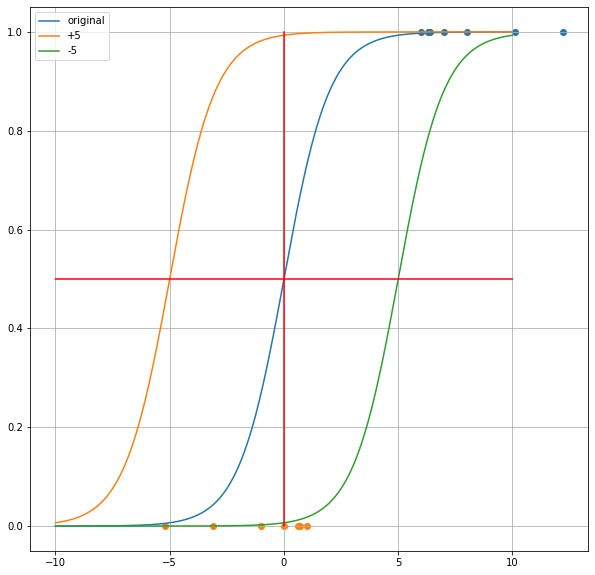

In [2]:
def sigmoide(x):
    return 1 / (1 + np.exp(-x))

X  = np.arange(-10,10,1/100)
Y  = sigmoide(X)
Y2 = sigmoide(X+5)
Y3 = sigmoide(X-5)

C = np.array([[1.4,1], 
              [1.3,1],
              [1,1],
              [2,1],
              [7.2,1],
              [5.1,1],
              [3,1]])

D = np.array([[1.4,0], 
              [1.3,0],
              [1,0],
              [2,0],
              [7.2,0],
              [5.1,0],
              [3,0]])

fig = plt.figure(figsize=(10,10))
plt.plot(X,Y, label="original")
plt.plot(X,Y2, label="+5")
plt.plot(X,Y3, label="-5")
plt.plot([0.,0.], [0.,1.], 'r')
plt.plot(X, 0*Y+0.5, 'r')
plt.scatter(C[:,0]+5,C[:,1])
plt.scatter(-D[:,0]+2,D[:,1])

plt.grid()
plt.legend()

## Derivada de la sigmoide

$$
\sigma(x) = \frac {1}{1 + e(-x)}
$$

$$ 
\sigma'(x) = \left( (1+\exp(-x))^{-1} \right)'= \left( {1+\exp(-x)}\right)^{-2} \cdot \frac {d}  {dx} \exp^{-x} 
$$

Entonces

$$ 
\sigma'(x) = (1+\exp(-x))^{-2} \cdot \exp^{-x} =  \frac {\exp^{-x}} {(1+\exp(-x))^{2}} = \frac {\exp^{-x}} {(1+\exp(-x))} \cdot \frac {1}{(1+\exp(-x))}
$$

Esto lo podemos reexpresar como:

$$ 
\sigma'(x) = \frac {\exp^{-x}} {(1+\exp(-x))} \cdot \frac {1}{(1+\exp(-x))} = \sigma(x) \cdot \frac {\exp^{-x}} {(1+\exp(-x))} = \sigma(x) \cdot \frac {\exp^{-x} + 1 - 1} {(1+\exp(-x))} = \sigma(x) \cdot (1 - \sigma(x))
$$


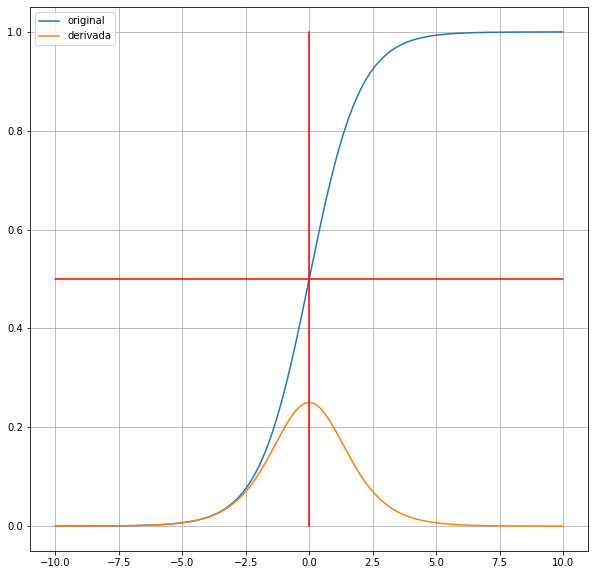

In [3]:
def sigmoide(x):
    return 1 / (1 + np.exp(-x))

def dsigmoide(x):
    return sigmoide(x)*(1- sigmoide(x))

X  = np.arange(-10,10,1/100)
Y  = sigmoide(X)
Y2 = dsigmoide(X)

fig = plt.figure(figsize=(10,10))
plt.plot(X,Y, label="original")
plt.plot(X,Y2, label="derivada")
plt.plot([0.,0.], [0.,1.], 'r')
plt.plot(X, 0*Y+0.5, 'r')
plt.grid()
plt.legend()

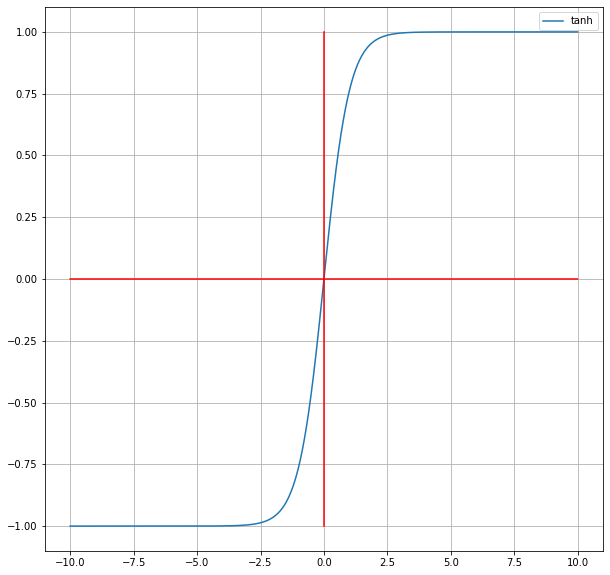

In [4]:
X  = np.arange(-10,10,1/100)
Y  = np.tanh(X)

fig = plt.figure(figsize=(10,10))
plt.plot(X,Y, label="tanh")
plt.plot(X, 0*Y, 'r')
plt.plot([0.,0.], [-1.,1.], 'r')

plt.grid()
plt.legend()

Si yo tengo una serie de puntos en $\mathcal{R^n}; n>2$ ¿cómo encuentro el mejor margen que los divide? (¿Cómo puedo ajustar la verosimilitud dada por los datos?) 

Es decir yo quiero maximizar la verosimilitud de un proceso de Bernoulli

$$
\operatorname{Pr}\left(Y=y_{i} \mid x_{i}\right)=\prod s_{\theta}\left(x_{i}\right)^{y_{i}}\left(1-s_{\theta}\left(x_{i}\right)\right)^{1-y_{i}}
$$

$$
\mathcal{L}=\log (\operatorname{Pr})=\sum y_{i} \log \left(s_{\theta}\left(x_{i}\right)\right)+\left(1-y_{i}\right)\left(\log \left(1-s_{\theta}\left(x_{i}\right)\right)\right)
$$

In [5]:
X,y = make_blobs(centers=2, n_features=2, n_samples=500, center_box=[(-4,3),(5,-1)],random_state=213)
Xn, Xt, yn, yt = train_test_split(X,y)

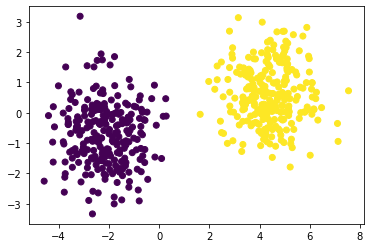

In [6]:
plt.scatter(X[:,0],X[:,1],c=y)

Una opción para encontrar las $\theta$ que máximas las probabilidades de la sigmoide y por lo tanto de $\mathcal{L}$ es el descenso del gradiente.

$$
\theta(t+1) = \theta(t) - \eta \cdot \nabla J(\theta(t))
$$

Y como función $J$ podemos ocupar a $-\mathcal{L}$

$$
\begin{aligned}
\frac{\partial J}{\partial \theta_{j}} &=-y_{i} \frac{s_{\theta}\left(x_{i}\right)\left(1-s_{\theta}\left(x_{i}\right)\right)}{s_{\theta}\left(x_{i}\right)} x_{j}-\left(y_{i}-1\right) \frac{s_{\theta}\left(x_{i}\right)\left(1-s_{\theta}\left(x_{i}\right)\right)}{1-s_{\theta}\left(x_{i}\right)} x_{j} \\
\frac{\partial J}{\partial \theta_{j}} &=-\left[y_{i}\left(1-s_{\theta}\left(x_{i}\right)\right)+\left(y_{i}-1\right) s_{\theta}\left(x_{i}\right)\right] x_{j} \\
\frac{\partial J}{\partial \theta_{j}} &=-\left[y_{i}-s_{\theta}\left(x_{i}\right)\right] x_{j} \\
\frac{\partial J}{\partial \theta_{j}} &=\left[s_{\theta}\left(x_{i}\right)-y_{i}\right] x_{j}
\end{aligned}
$$

Haciendo $\Delta \equiv s_{\theta}\left(x_{i}\right)-y_{i}$ obtengo

$$
\frac{\partial J}{\partial \theta_{j}} = \Delta_i x_j
$$

In [7]:
def agrega_bias(X):
    n,d = X.shape
    u = np.ones((n,1))
    return np.hstack((u,X))

def estandariza(X):
    return (X - X.mean(axis=0)) / X.std(axis=0)

def normaliza(X):
    rg = np.amin(X,axis=0) - np.amax(X,axis=0)
    return (X+X.min(axis=0))/rg

def loglikelihood(H,y,th):
    return (-np.dot(y,np.log(H)) - np.dot((1-y),np.log(1-H)))

def sigmoide(z):
    return 1/(1 + np.exp(-z))

def score(th,X):
    return sigmoide(np.dot(X,th))

def gradiente(w,X,y):
    h = sigmoide(np.dot(X,w))
    z = h.T - y
    gr = np.dot(X.T, z.T)
    return gr
    
def grad_desc(X,y,iters, a=0.01,t=100, tol=1e-4):
    #gr = lambda w, X, y: dot(X.T, (sigmoide(w.T,X.T) - y).T)
    n, d = X.shape
    pesos = np.random.ranf((1,d))
    w = pesos[-1]
    #print(pesos)
    h  = sigmoide(np.dot(X,w))
    j  = loglikelihood(h,y,w)
    costos = [j]
    for i in range(iters):
        gr = gradiente(w,X,y)
        w -= a*gr
        pesos  = np.vstack((pesos,w))
        h  = sigmoide(np.dot(X,w))
        j  = loglikelihood(h,y,w)
        costos.append(j)
        if(i%t==0 or j < tol):
            print('{0}:{1}'.format(i,j))
        if(j<tol):
            break
    return w, pesos, costos

Xs = normaliza(X)
#plt.scatter(Xs[:,0],Xs[:,1],c=y)
Xb = agrega_bias(Xs)
Xt, Xp, yt, yp = train_test_split(Xb, y)
wf, W, J = grad_desc(Xt,yt,15000,0.05, t=1000)

0:555.4900266226568
1000:1.044293174000912
2000:0.6246208105396185
3000:0.45812439166738006
4000:0.3660606179137965
5000:0.306800071811659
6000:0.26512273507511813
7000:0.23405121319939248
8000:0.20990666147828385
9000:0.19055397533279544
10000:0.1746637353205987
11000:0.16136237275772844
12000:0.15005084801474772
13000:0.1403038940474341
14000:0.13181080926882435


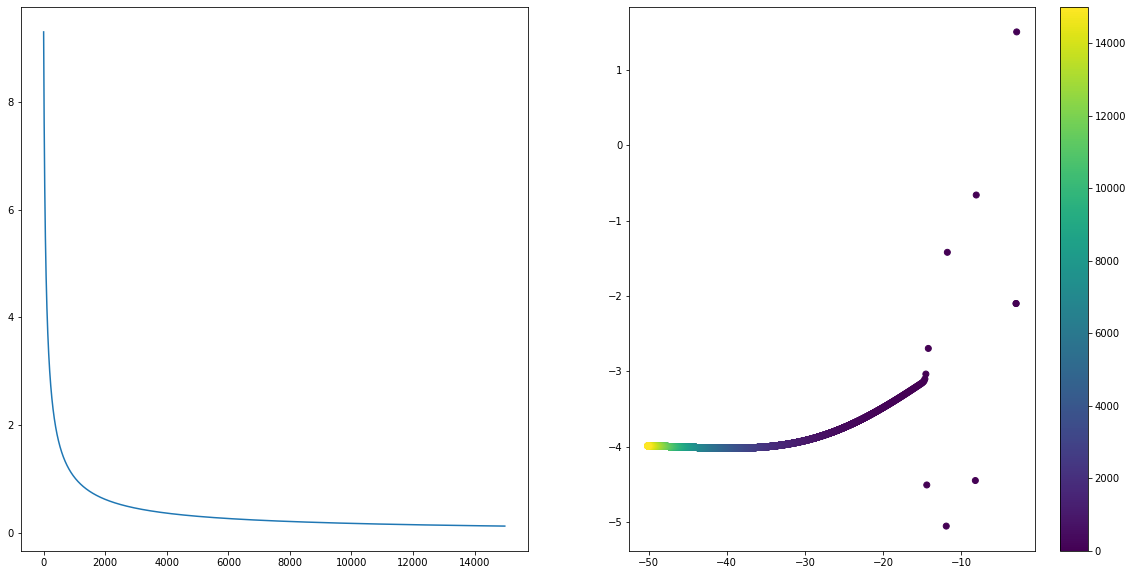

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.plot(J[20:])
im = ax2.scatter(W[:,1], W[:,2], c=range(len(W)))
fig.colorbar(im,ax=ax2)

In [9]:
h = sigmoide(np.dot(Xp,wf))
S = loglikelihood(h,yp,wf)
print("Erorr {0}".format(S))

print(confusion_matrix(np.round(h), yp))

Erorr 0.239151174774878
[[58  0]
 [ 0 67]]


In [96]:
for vv,vp in zip(h,yp):
    print("{0} : {1}".format(round(vv),vp))


0 : 0
0 : 0
1 : 1
0 : 0
0 : 0
0 : 0
1 : 1
1 : 1
0 : 0
1 : 1
0 : 0
0 : 0
0 : 0
1 : 1
0 : 0
1 : 1
0 : 0
0 : 0
1 : 1
1 : 1
0 : 0
0 : 0
0 : 0
1 : 1
1 : 1
1 : 1
1 : 1
0 : 0
1 : 1
1 : 1
0 : 0
1 : 1
0 : 0
1 : 1
1 : 1
1 : 1
0 : 0
0 : 0
0 : 0
1 : 1
1 : 1
0 : 0
1 : 1
1 : 1
0 : 0
1 : 1
0 : 0
1 : 1
0 : 0
1 : 1
1 : 1
1 : 1
1 : 1
0 : 0
1 : 1
0 : 0
0 : 0
0 : 0
0 : 0
0 : 0
0 : 0
0 : 0
0 : 0
0 : 0
1 : 1
1 : 1
0 : 0
1 : 1
1 : 1
1 : 1
0 : 0
0 : 0
0 : 0
1 : 1
1 : 1
0 : 0
0 : 0
0 : 0
0 : 0
0 : 0
0 : 0
1 : 1
1 : 1
0 : 0
0 : 0
1 : 1
0 : 0
1 : 1
0 : 0
1 : 1
0 : 0
0 : 0
0 : 0
1 : 1
1 : 1
0 : 0
0 : 0
0 : 0
0 : 0
0 : 0
0 : 0
0 : 0
0 : 0
0 : 0
1 : 1
1 : 1
1 : 1
0 : 0
0 : 0
1 : 1
1 : 1
1 : 1
0 : 0
0 : 0
1 : 1
1 : 1
0 : 0
1 : 1
1 : 1
1 : 1
0 : 0
1 : 1
1 : 1
1 : 1
0 : 0


## Dataset con círculos

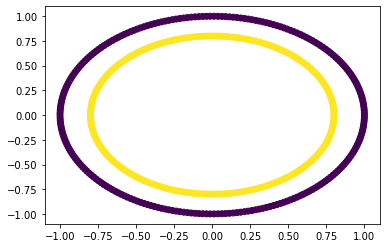

In [97]:
C,c = make_circles(500, random_state=1234) 

plt.scatter(C[:,0],C[:,1],c=c)